### Overview

In this notebook, we will collect data on overall sentiment across various industries from 2015 to 2023 and analyze frequently mentioned keywords in employees' pros and cons.


Sample: 100 000 reviews
- Current Employee: 53730
- Former Employee: 46270

### Import libraries with neccessary functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import spacy
from collections import Counter
from textblob import TextBlob


### Import initial dataset from Kaggle

In [5]:
reviews = pd.read_csv("../data/raw/all_reviews.csv", low_memory=False)
pd.set_option('display.max_columns', None)


### Initial cleaning

In [6]:
# Function to clean numerical rating columns
def clean_rating_columns(df, columns):
    """
    Clean numerical rating columns by converting them to float and removing invalid entries.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
        df[col] = df[col].astype(float)
    return df

# Function to handle missing values
def handle_missing_values(df, columns_to_fill, fill_value=0.0):
    """
    Fill missing values for specified columns with a given value.
    """
    for col in columns_to_fill:
        df[col] = df[col].fillna(fill_value).astype(float)
    return df

# Function to extract year from date
def extract_year(df, date_column, year_column):
    """
    Extract the year from a date column and create a new year column.
    """
    df[year_column] = df[date_column].str.split().str[2].astype(int)
    df.drop(columns = "date", inplace = True)
    return df[df[year_column] > 2014]

# Function to extract firm names from the firm_link
def extract_firm_names(df, firm_link_column, firm_name_column):
    """
    Extract firm names from firm_link and filter firms with frequent mentions.
    """
    def extract_name(firm_link):
        match = re.search(r'(?<=/)([A-Za-z0-9\-]+)(?=-Reviews)', firm_link)
        return match.group(1) if match else None

    df[firm_name_column] = df[firm_link_column].apply(extract_name)
    df.drop(columns = "firm_link", inplace=True)
    firm_counts = df[firm_name_column].value_counts()
    valid_firms = firm_counts[firm_counts >= 100].index
    
    return df[df[firm_name_column].isin(valid_firms)]

# Function to unify employment statuses
def unify_employment_statuses(df, status_column):
    """
    Standardize employment statuses.
    """
    def unify_status(status):
        if "Current" in status:
            if "Contractor" in status:
                return "Current Contractor"
            elif "Freelancer" in status:
                return "Current Freelancer"
            elif "Intern" in status:
                return "Current Intern"
            elif "Self-employed" in status:
                return "Current Self-employed"
            else:
                return "Current Employee"
        elif "Former" in status:
            if "Contractor" in status:
                return "Former Contractor"
            elif "Freelancer" in status:
                return "Former Freelancer"
            elif "Intern" in status:
                return "Former Intern"
            elif "PhD" in status:
                return "Former PhD"
            elif "Self-employed" in status:
                return "Former Self-employed"
            else:
                return "Former Employee"
        else:
            return "Other"

    df[status_column] = df[status_column].apply(unify_status)
    return df

# Main cleaning function
def clean_dataset(file_path, rating_columns, missing_columns, firm_link_column, status_column, date_column, year_column, job_column):
    """
    Clean the dataset by applying all cleaning functions step by step.
    """
    # Read the data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Clean rating columns
    df = clean_rating_columns(df, rating_columns)
    
    # Drop unnecessary columns
    df.drop(columns=["title", "advice", "index", "Business Outlook"], inplace=True)
    
    # Drop rows with significant missing values
    df.dropna(subset=['pros', 'cons', 'Culture & Values'], inplace=True)

    #Unify names of the columns and reset index
    df['pros'] = df['pros'].str.lower().str.replace(r'\n', ' ', regex=True)
    df['cons'] = df['cons'].str.lower().str.replace(r'\n', ' ', regex=True)
    
    
    # Extract year and filter rows
    df = extract_year(df, date_column, year_column)
    
    # Handle missing values in specific columns
    df = handle_missing_values(df, missing_columns, fill_value=0.0)
    
    # Extract and filter firm names
    df = extract_firm_names(df, firm_link_column, 'firm_name')

    # Unify employment statuses
    df = unify_employment_statuses(df, status_column)
    
    return df

# Usage
file_path = "../data/raw/all_reviews.csv"
rating_columns = ['Work/Life Balance', 'Compensation and Benefits', 'Senior Management', 'Career Opportunities']
missing_columns = ['Diversity & Inclusion']
firm_link_column = 'firm_link'
status_column = 'status'
date_column = 'date'
year_column = 'year'
job_column = 'job'

cleaned_reviews = clean_dataset(
    file_path=file_path,
    rating_columns=rating_columns,
    missing_columns=missing_columns,
    firm_link_column=firm_link_column,
    status_column=status_column,
    date_column=date_column,
    year_column=year_column,
    job_column=job_column
)


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/4252623836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/4252623836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


### Cleaning job titles

In [7]:
def clean_job_titles(df, job_column):
    """
    Clean and standardize job titles in a DataFrame.

    """
    # Replace empty strings or NaN values with "Anonymous Employee"
    df[job_column].replace(' ', 'Anonymous Employee', inplace=True)
    df[job_column].fillna('Anonymous Employee', inplace=True)
    
    # Strip leading/trailing spaces
    df[job_column] = df[job_column].str.strip()
    
    # Count occurrences of each job title
    job_counts = df[job_column].value_counts()
    
    # Filter out jobs mentioned less than 100 times
    valid_jobs = job_counts[job_counts >= 100].index
    df = df[df[job_column].isin(valid_jobs)]
    
    # Replace specific job titles
    job_replacements = {
        'Salees Associate': 'Sales Associate', 'Sales Executive': 'Sales Associate',
        'IT Strategy Consultant': 'IT Consultant',
        'Sales Associate/Cashier': 'Cashier', 'Front End Cashier': 'Cashier',
        'Senior Software Engineer': 'Software Engineer', 
        'Senior Systems Engineer': 'Software Engineer', 
        'Senior Software Developer': 'Software Engineer', 
        'Associate Software Engineer': 'Software Engineer',
        'Sales': 'Sales Associate', 
        'Salees Associate ': 'Sales Associate', 
        'Retail Sales Associate': 'Sales Associate',
        'Sales Assistant': 'Sales Associate', 
        'Sales Representative': 'Sales Associate', 'Inside Sales Representative': 'Sales Associate',
        'Systems Engineer': 'Software Engineer', 'Senior Engineer':'Software Engineer',
        'Senior Associate': 'Associate', 
        'Senior Analyst ': 'Analyst',
        'Business Analyst': 'Analyst', 'Senior Business Analyst ': 'Analyst','Senior Business Analyst': 'Analyst', 'Financial Analyst': 'Analyst',
        'IT Analyst': 'Analyst', 'Senior Analyst': 'Analyst', 'Programmer Analyst': 'Analyst',
        'Server': 'Waiter/Waitress', 'Waiter': 'Waiter/Waitress', 'Waitress': 'Waiter/Waitress',
        'Warehouse Worker': 'Warehouse Associate',
        'Human Resources': 'HR', 
        'Recruiter': 'HR',
        'Customer Service Representative': 'Customer Service', 
        'Customer Service Representative (CSR)': 'Customer Service', 'Customer Service Specialist': 'Customer Service',
        'Customer Assistant': 'Customer Service', 
        'Customer Service Associate': 'Customer Service',
        'Executive Assistant': 'Administrative Assistant', 
        'Associate Director': 'Director',
        'Shift Supervisor': 'Supervisor',
        'Graduate Research Assistant': 'Researcher','Research Assistant': 'Researcher',
    }
    df[job_column] = df[job_column].replace(job_replacements)
    
    # Apply broader job title standardizations
    def standardize_jobs(job):
        if 'Teacher' in job:
            return 'Teacher'
        elif 'Manager' in job:
            return 'Manager'
        elif 'Consultant' in job:
            return 'Consultant'
        elif 'Teller' in job:  
            return 'Bank Teller'
        elif 'Intern' in job:
            return 'Intern'
        elif 'Pharmacy' in job:
            return 'Pharmacy'
        elif 'Team Member' in job or 'Crew Member' in job:
            return 'Team Member'
        return job
    
    df[job_column] = df[job_column].apply(standardize_jobs)
    
    return df

cleaned_reviews = clean_job_titles(cleaned_reviews, 'job') #apply the job cleaning function

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/2627540091.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].replace(job_replacements)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/2627540091.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].apply(standardize_jobs)


### Creating industries

In [8]:
# dictionary mapping companies to industries
industry_mapping = {
    'Technology': [
        'CGI', 'Amazon-Flex', 'Publicis-Sapient', 'Pegasystems', 'Tech-Data', 'Unity', 
        'Stefanini', 'Tata-Group', 'Tata-AIA-Life', 'Hi-Rez-Studios', 'Aujas', 
        'S-and-C-Electric-Company', 'LGC', 'TecOrb-Technologies', 'Tower-Semiconductor',
        'CA-Technologies', 'Sysco', 'ALSTOM', 'The-UPS-Store', 'COLSA', 'Hindustan-Times', 
        'Vista-College', 'DreamWorks-Animation', 'Hi-Rez-Studios', 'GlobalData', 'RH', 
        'HUB-International', 'Apex-Tool-Group', 'Conair', 'Emco-Corporation', 'CARQUEST', 
        'Orora', 'Hi-Rez-Studios', 'Electronic-Transaction-Consultants', 'Tower-Semiconductor',
        '3D-Systems', 'Toshiba-America-Business-Solutions', 'Jet', 'Rexel-Group', 'Portland-Communications',
        'Quinnox', 'Quikr-India', 'Tradeindia-com-Infocom-Network','Seiko-Epson', 'SKP-Group', 'REVE-Systems', 'Promact-InfoTech-Pvt'
    ],
    'Finance': [
        'Goldman-Sachs', 'Canada-Life', 'UBS', 'United-Bank-for-Africa', 'Rabobank', 
        'AXA-UK', 'Mercury-General', 'RLI', 'Ecobank', 'Intrum', 'Cadence-Financial', 'ICBC'
    ],
    'Retail': [
        'Chipotle', 'Dunkin', 'H-E-B', 'Ross-Stores', 'GameStop', 'Swarovski', 
        'Calvin-Klein', 'Gymboree', 'Men-s-Wearhouse', 'Famous-Dave-s', 'Savers-Health-and-Beauty', 
        'CARQUEST', 'Orora', 'CALVIN-KLEIN','SeaWorld-Parks-and-Entertainment', 'Lettuce-Entertain-You', 'Wayne-Sanderson-Farms', 'Marc-Glassman'
    ],
    'Healthcare': [
        'Beaumont-Health', 'Nuffield-Health', 'Texas-Health-and-Human-Services-Commission', 
        'Special-Olympics', 'Legacy-Healthcare-Services', 'Indian-Health-Service', 'Extendicare', 
        'Summa-Health-System', 'WW-WeightWatchers', 'WellSky', 'Atrium'
    ],
    'Energy': [
        'Valeo', 'Enersys', 'EnerSys','Hydro-One', 'Vallourec', 'Petrofac'
    ],
    'Media_and_Entertainment': [
        'Norwegian-Cruise-Line-Holdings-Ltd', 'Newsquest', 'Schibsted','DreamWorks-Animation', 'National-Geographic-Society'
    ],
    'Food_and_Beverage': [
        'Tyson-Foods', 'HP-Hood', 'Famous-Dave-s', 'Pernod-Ricard'
    ],
    'Aerospace_and_Defense': [
        'COLSA', 'Stefanini', 'Hi-Rez-Studios'
    ],
    'Consumer_Goods': [
        'Coty', 'GlobalData', 'Movado-Group','Milliken', 'Do-it-Best', 'BBDO', 'Savers-Health-and-Beauty', 'Purity-Cosmetics'
    ],
    'Public_Sector': [
        'New-York-County-District-Attorney', 'Army-Family-and-MWR-Programs', 'Commonwealth-of-Virginia',
        'Palm-Beach-County-School-District', 'University-of-Nevada-Las-Vegas', 'Binding-Site'
    ],
    'Transportation_and_Logistics': [
        'Alaska-Airlines', 'DHL', 'Trinity-Industries','Crowley','Group-1-Automotive', 'Meritage-Homes', 'Jet', 'Rexel-Group',  'Avianca', 'Arriva-Group'
    ],
    'Business_Services': [
        'TriNet', 'NIBCO', 'The-Select-Group','Cpl-Resources', 'Afni', 'EOS-Group', 'Barton-Malow', 'ProTransport-1', 'Portland-Communications', 'Vivo-Global'
    ],
    'Automotive': [
        'Hendrick-Automotive-Group', 'Brose', 'Wayne-Sanderson-Farms'
    ],
    'Education': [
        'Carleton-University', 'Brown-University', 'William-and-Mary', 'Valencia-College', 'Toshiba-America-Business-Solutions'
    ],
    'Telecommunication': ['M1', 'AFL']

}



# create a new column by mapping the firm names to their respective industry
def map_industry(firm_name):
    for industry, companies in industry_mapping.items():
        if firm_name in companies:
            return industry
    return 'Other'  # default category for companies not in the mapping


sampled_reviews = cleaned_reviews.head(100000)
# apply the function to the sampled_reviews DataFrame
sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/1163099893.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)


### Get emotional status

In [9]:
# Function to flag stress, burnout, and anxiety
def emotional_status(text):
    if not isinstance(text, str):  # check if text is not None or NaN
        return False, False, False, False, False, False  # return False for all flags if the text is invalid

    text = text.lower()

    # Keywords for flags
    stress_keywords = ['stress', 'overwhelmed', 'nervous', 'pressure', 'stressful', 'deadlines', 'high demand', 'time pressure',
                       'workload', 'tension', 'deadlines pressure', 'tight schedules','high workload']
    toxic_keywords = ['toxic','negative', 'micromanagement', 'lack of support', 'hostile', 'bullying', 
                      'favoritism', 'harassment', 'isolation', 'unfair', 'discrimination']
    burnout_keywords = ['burnout', 'overtasked', 'overworked', 'burned out', 'burning out', 
                        'drained', 'mental fatigue', 'overcommitment', 'work-life imbalance','exhaustion', 'fatigue']
    anxiety_keywords = ['anxious', 'anxiety', 'panic', 'workload stress', 'job insecurity', 
                        'constant worry', 'fear', 'insecurity']
    depression_keywords= ['depressed','sad','no motivation', 'sleepless', 'unmotivated', 'headaches',
                          'hopelessness', 'lethargy', 'apathy', 'no energy', 'self-doubt', 'dissatisfaction', 'feeling worthless']
    supportive_keywords = ['supportive', 'understanding', 'encouraging', 'teamwork', 'mentorship', 'recognition',
                           'respect', 'empowerment', 'inclusion', 'constructive feedback']    

    # removing unwanted phrases
    unwanted_phrases = ['not too stressful', 'no negatives', 'no cons', 'no complaints', 'not too stressfull']
    if any(phrase in text for phrase in unwanted_phrases):
        if any(keyword in text for keyword in supportive_keywords):
            # keep the text because it includes supportive aspects
            return False, False, False, False, True, False  # supportive flag is True
        else:
            # discard the text as it is negating sentiment
            return False, False, False, False, False, False



    # check for each set of keywords
    stress_flag = any(keyword in text for keyword in stress_keywords)
    burnout_flag = any(keyword in text for keyword in burnout_keywords)
    anxiety_flag = any(keyword in text for keyword in anxiety_keywords)
    toxic_flag = any(keyword in text for keyword in toxic_keywords)
    supportive_env_flag = any(keyword in text for keyword in supportive_keywords)
    depression_flag = any(keyword in text for keyword in depression_keywords)
    
    return stress_flag, burnout_flag, anxiety_flag, toxic_flag, supportive_env_flag, depression_flag



In [10]:
# apply the emotional_status function to "pros" and "cons"
sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
    sampled_reviews['pros'].apply(emotional_status).tolist(), index=sampled_reviews.index)

sampled_reviews[['stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons', 'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag_cons']] = pd.DataFrame(
    sampled_reviews['cons'].apply(emotional_status).tolist(), index=sampled_reviews.index)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/1265215062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/1265215062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] 

In [19]:
sampled_reviews.columns = sampled_reviews.columns.str.lower().str.replace(" ", "_", regex=True).str.replace("&", "and", regex=True)
sampled_reviews.reset_index(drop=True, inplace=True)
print(sampled_reviews.shape)

(100000, 32)


In [12]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the sentiment analysis function to 'pros' and 'cons'
sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/1633712011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1195/1633712011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))


In [16]:
sampled_reviews.columns = sampled_reviews.columns.str.lower().str.replace(" ", "_", regex=True).str.replace("&", "and", regex=True)
sampled_reviews.reset_index(drop=True, inplace=True)
print(sampled_reviews.shape)

(100000, 32)


### Well-being Indicators

In [22]:
 #list of emotional flags (just the pros flags)
combined_flags = [
    'stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag'
]

combined_flags_df = sampled_reviews.copy()

# combine the pros and cons flags for each emotional state
for flag in combined_flags:
    # Combine the 'pros' and 'cons' flags using the logical OR (|)
    combined_flags_df[flag] = combined_flags_df[flag] | combined_flags_df[flag + '_cons']

# drop the cons flags from the dataframe
for flag in combined_flags:
    combined_flags_df.drop(columns=[flag + '_cons'], inplace=True)

# Check the dataframe to see if the flags have been combined correctly
display(combined_flags_df[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].head())

stress_flag  burnout_flag  anxiety_flag  toxic_flag  supportive_env_flag  \
0        False         False         False       False                False   
1        False         False         False       False                False   
2        False         False         False       False                False   
3        False         False         False       False                False   
4        False         False         False       False                False   

   depression_flag  
0            False  
1            False  
2            False  
3            False  
4            False

### Word frequency counts in reviews

In [99]:
nlp = spacy.load('en_core_web_sm')


# Use your preprocessing function
def preprocess_text_spacy(text):
    # Parse the text using SpaCy
    doc = nlp(text.lower())
    
    # Filter tokens: keep only alphabetic words, exclude stopwords and punctuation
    """
    #token.is_alpha: This condition filters out any tokens that are not alphabetic (e.g., numbers, punctuation)
    not token.is_stop: This excludes common stopwords (e.g., "the", "a", "and") 
    token.lemma_: converts each word to its base form (lemma). For example, "running" becomes "run", and "better" becomes "good".
    """
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.text not in ['pros', 'cons']]
    
    #  after filtering and lemmatizing, the individual tokens (words) are joined back into a single string with spaces separating them.
    processed_text = ' '.join(tokens)
    
    return processed_text

# function to get word frequencies from text data
def get_word_frequencies(text_data):
    # preprocess the text and then tokenize
    """
    ' '.join(text_data): joins the list of processed text (from multiple reviews) into a single string
    .split(): splits the string into a list of individual words

    Counter(all_words) counts how many times each word appears in the list of words, it returns a dictionary-like object where keys are words, and values are their respective frequencies

    """
    all_words = ' '.join(text_data).split()
    word_freq = Counter(all_words)
    return word_freq


# Function to get word frequencies by industry
def get_word_frequencies_by_industry(df, text_column, industry_column):
    """
     Groups the reviews by industry and processes the text in the specified column 
     For each industry, the word frequencies are calculated and returned in a dictionary

    """
    industry_word_freq = {} # this will store word frequencies for each industry
    
    for industry in df[industry_column].unique():
        # filter reviews for each industry
        filtered_reviews = df[df[industry_column] == industry][text_column]
        
        # Preprocess and get word frequencies for these filtered reviews
        processed_reviews = filtered_reviews.apply(preprocess_text_spacy)
        word_freq = get_word_frequencies(processed_reviews)
        
        industry_word_freq[industry] = word_freq
    
    return industry_word_freq

# Get word frequencies for 'pros' and 'cons' grouped by industry
pros_word_freq_by_industry = get_word_frequencies_by_industry(sampled_reviews, 'pros', 'industry')
cons_word_freq_by_industry = get_word_frequencies_by_industry(sampled_reviews, 'cons', 'industry')


### Top 10 keywords for each industry

In [100]:
from collections import Counter

# Function to get top N keywords by frequency for each industry
def get_top_keywords_by_industry(df, text_column, industry_column, top_n=10):
    industry_keywords = {}  # this will store top N keywords for each industry
    
    # Get word frequencies by industry
    industry_word_freq = get_word_frequencies_by_industry(df, text_column, industry_column)
    
    for industry, word_freq in industry_word_freq.items():
        # Get the top N words by frequency
        top_keywords = [word for word, _ in word_freq.most_common(top_n)]
        industry_keywords[industry] = top_keywords
    
    return industry_keywords

# Get top 10 keywords for 'pros' by industry
top_keywords_pros_by_industry = get_top_keywords_by_industry(sampled_reviews, 'pros', 'industry')

# Get top 10 keywords for 'cons' by industry
top_keywords_cons_by_industry = get_top_keywords_by_industry(sampled_reviews, 'cons', 'industry')


### Create wordclouds of pros & cons per each industry

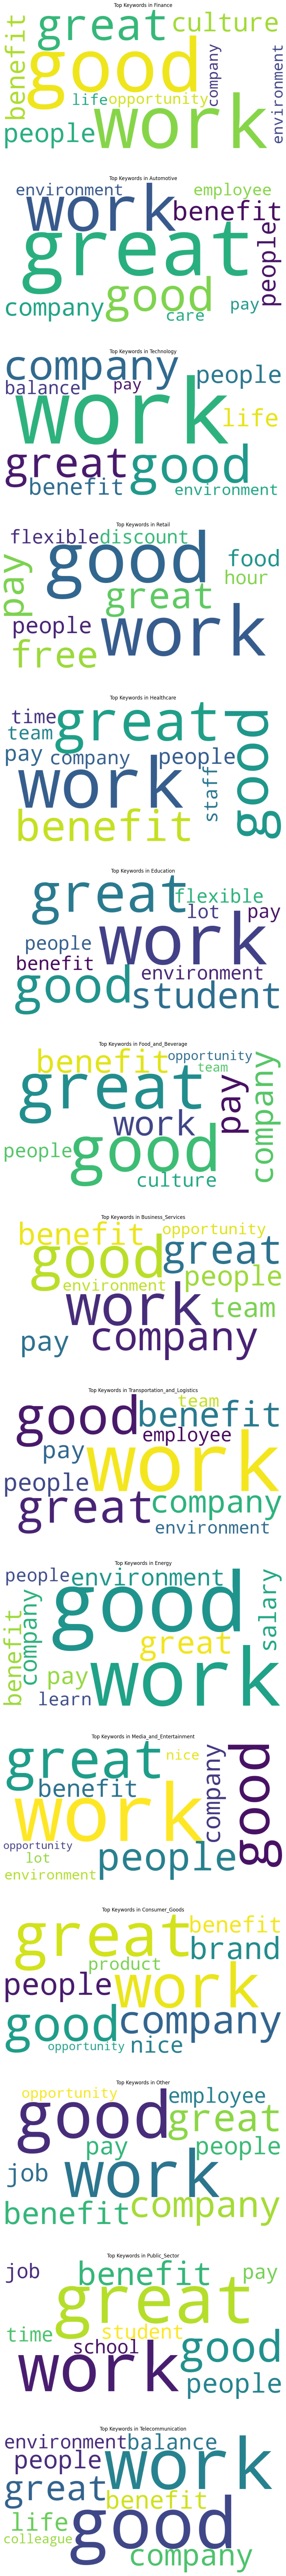

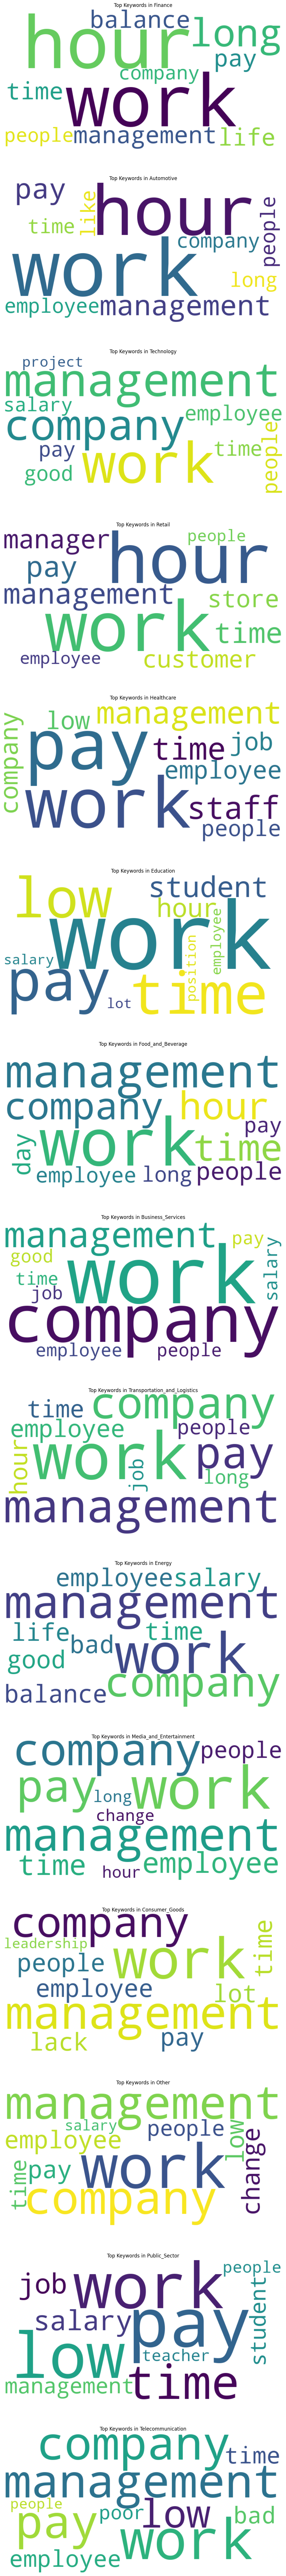

In [105]:
from wordcloud import WordCloud

# Function to generate word clouds for top keywords by industry
def generate_wordcloud_by_industry(industry_keywords):
    num_industries = len(industry_keywords)
    
    # Set up the plot
    fig, axes = plt.subplots(num_industries, 1, figsize=(10, num_industries*6))
    if num_industries == 1:
        axes = [axes]  # To ensure axes is always iterable
    
    for ax, (industry, keywords) in zip(axes, industry_keywords.items()):
        # Create a frequency dictionary for wordcloud
        word_freq = {word: 1 for word in keywords}
        
        # Create the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        # Display the word cloud
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Top Keywords in {industry}")
        ax.axis('off')  # Turn off axis
        
    plt.tight_layout()
    plt.show()

# Generate word clouds for top 10 keywords for pros by industry
generate_wordcloud_by_industry(top_keywords_pros_by_industry)

# Generate word clouds for top 10 keywords for cons by industry
generate_wordcloud_by_industry(top_keywords_cons_by_industry)


### Convert keywords to dataframes

In [109]:
# convert the industry_keywords dictionary to a DataFrame
def convert_keywords_to_dataframe(industry_keywords):
    # Create an empty list to store rows
    rows = []
    
    # iterate over the industries and their keywords
    for industry, keywords in industry_keywords.items():
        # create a dictionary for each row
        row = {'Industry': industry}
        for i, keyword in enumerate(keywords, 1):  # start from 1 for ranking
            row[f'Keyword_{i}'] = keyword
        rows.append(row)
    
    # create the DataFrame
    df = pd.DataFrame(rows)
    
    return df

# get DataFrame for pros by industry
pros_df = convert_keywords_to_dataframe(top_keywords_pros_by_industry)

# get DataFrame for cons by industry
cons_df = convert_keywords_to_dataframe(top_keywords_cons_by_industry)

# save the DataFrames to CSV or Excel
pros_df.to_csv("../data/clean/top_keywords_pros_by_industry.csv")
cons_df.to_csv("../data/clean/top_keywords_cons_by_industry.csv")

In [131]:
# Grouping by 'job' and 'year' to calculate mean for each column
job_trends = sampled_reviews.groupby(['job', 'year']).agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()

#update job titles
job_replacements = {
        '.NET Developer': 'Software Engineer',
        'Software Developer' : 'Software Engineer',
        'Embedded Software Engineer' : 'Software Engineer',
        'Senior Game Advisor' : 'Game Advisor' }

job_trends['job'] = job_trends['job'].replace(job_replacements)
job_trends = job_trends.round(2)
# display the resulting aggregated data
display(job_trends)

job  year  pros_sentiment  cons_sentiment  rating  \
0     Software Engineer  2015            0.14            0.00     3.0   
1     Software Engineer  2017            0.46           -0.35     2.0   
2     Software Engineer  2018            0.05           -0.21     2.5   
3     Software Engineer  2020            0.35           -0.08     4.0   
4     Software Engineer  2021            0.48           -0.06     3.4   
...                 ...   ...             ...             ...     ...   
9123    Working Student  2023            0.80            0.70     5.0   
9124             Writer  2016            0.69           -0.03     1.0   
9125             Writer  2019            0.54            0.42     4.5   
9126             Writer  2021            0.55            0.02     4.0   
9127        Yard Worker  2017            0.54            0.25     4.0   

      work/life_balance  compensation_and_benefits  culture_and_values  \
0                   4.0                        4.0                 3.0   
1                   3.0                        3.0                 2.0   
2                   3.0                        2.0                 3.0   
3                   5.0                        3.0                 4.0   
4                   3.4                        3.0                 3.8   
...                 ...                        ...                 ...   
9123                3.0                        5.0                 5.0   
9124                3.0                        1.0                 1.0   
9125                4.5                        4.5                 5.0   
9126                4.5                        4.0                 4.5   
9127                4.0                        4.0                 4.0   

      senior_management  diversity_and_inclusion  
0                   2.0                      0.0  
1                   2.0                      0.0  
2                   1.5                      0.0  
3                   4.0                      4.0  
4                   3.2                      3.4  
...                 ...                      ...  
9123                5.0                      5.0  
9124                1.0                      0.0  
9125                4.5                      0.0  
9126                4.0                      4.0  
9127                4.0                      0.0  

[9128 rows x 10 columns]

In [133]:
job_trends['overall_sentiment'] = (job_trends['pros_sentiment'] + job_trends['cons_sentiment']) / 2

# assign equal weights to pros and cons
pros_weight = 0.5
cons_weight = 0.5

# calculate overall sentiment with equal weights
job_trends['overall_sentiment'] = (job_trends['pros_sentiment'] * pros_weight + 
                                    job_trends['cons_sentiment'] * cons_weight)

def classify_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

job_trends['sentiment_category'] = job_trends['overall_sentiment'].apply(classify_sentiment)
job_trends


job  year  pros_sentiment  cons_sentiment  rating  \
0     Software Engineer  2015            0.14            0.00     3.0   
1     Software Engineer  2017            0.46           -0.35     2.0   
2     Software Engineer  2018            0.05           -0.21     2.5   
3     Software Engineer  2020            0.35           -0.08     4.0   
4     Software Engineer  2021            0.48           -0.06     3.4   
...                 ...   ...             ...             ...     ...   
9123    Working Student  2023            0.80            0.70     5.0   
9124             Writer  2016            0.69           -0.03     1.0   
9125             Writer  2019            0.54            0.42     4.5   
9126             Writer  2021            0.55            0.02     4.0   
9127        Yard Worker  2017            0.54            0.25     4.0   

      work/life_balance  compensation_and_benefits  culture_and_values  \
0                   4.0                        4.0                 3.0   
1                   3.0                        3.0                 2.0   
2                   3.0                        2.0                 3.0   
3                   5.0                        3.0                 4.0   
4                   3.4                        3.0                 3.8   
...                 ...                        ...                 ...   
9123                3.0                        5.0                 5.0   
9124                3.0                        1.0                 1.0   
9125                4.5                        4.5                 5.0   
9126                4.5                        4.0                 4.5   
9127                4.0                        4.0                 4.0   

      senior_management  diversity_and_inclusion  overall_sentiment  \
0                   2.0                      0.0              0.070   
1                   2.0                      0.0              0.055   
2                   1.5                      0.0             -0.080   
3                   4.0                      4.0              0.135   
4                   3.2                      3.4              0.210   
...                 ...                      ...                ...   
9123                5.0                      5.0              0.750   
9124                1.0                      0.0              0.330   
9125                4.5                      0.0              0.480   
9126                4.0                      4.0              0.285   
9127                4.0                      0.0              0.395   

     sentiment_category  
0               Neutral  
1               Neutral  
2               Neutral  
3              Positive  
4              Positive  
...                 ...  
9123           Positive  
9124           Positive  
9125           Positive  
9126           Positive  
9127           Positive  

[9128 rows x 12 columns]

In [124]:
job_trends

job  year  pros_sentiment  cons_sentiment  rating  \
0     Software Engineer  2015            0.14            0.00     3.0   
1     Software Engineer  2017            0.46           -0.35     2.0   
2     Software Engineer  2018            0.05           -0.21     2.5   
3     Software Engineer  2020            0.35           -0.08     4.0   
4     Software Engineer  2021            0.48           -0.06     3.4   
...                 ...   ...             ...             ...     ...   
9123    Working Student  2023            0.80            0.70     5.0   
9124             Writer  2016            0.69           -0.03     1.0   
9125             Writer  2019            0.54            0.42     4.5   
9126             Writer  2021            0.55            0.02     4.0   
9127        Yard Worker  2017            0.54            0.25     4.0   

      work/life_balance  compensation_and_benefits  culture_and_values  \
0                   4.0                        4.0                 3.0   
1                   3.0                        3.0                 2.0   
2                   3.0                        2.0                 3.0   
3                   5.0                        3.0                 4.0   
4                   3.4                        3.0                 3.8   
...                 ...                        ...                 ...   
9123                3.0                        5.0                 5.0   
9124                3.0                        1.0                 1.0   
9125                4.5                        4.5                 5.0   
9126                4.5                        4.0                 4.5   
9127                4.0                        4.0                 4.0   

      senior_management  diversity_and_inclusion  overall_sentiment  \
0                   2.0                      0.0              0.070   
1                   2.0                      0.0              0.055   
2                   1.5                      0.0             -0.080   
3                   4.0                      4.0              0.135   
4                   3.2                      3.4              0.210   
...                 ...                      ...                ...   
9123                5.0                      5.0              0.750   
9124                1.0                      0.0              0.330   
9125                4.5                      0.0              0.480   
9126                4.0                      4.0              0.285   
9127                4.0                      0.0              0.395   

     sentiment_category  
0               Neutral  
1               Neutral  
2               Neutral  
3              Positive  
4              Positive  
...                 ...  
9123           Positive  
9124           Positive  
9125           Positive  
9126           Positive  
9127           Positive  

[9128 rows x 12 columns]

In [140]:
sentiment_per_job = job_trends.groupby(['job', 'sentiment_category'])['overall_sentiment'].mean().reset_index()


# Sort by sentiment score for better visualization
sentiment_per_job = sentiment_per_job.sort_values(by='overall_sentiment', ascending=False)

# Display the result
display(sentiment_per_job)
#sentiment_per_job.to_csv("../data/clean/sentiment_per_job.csv")

job sentiment_category  overall_sentiment
3047  Senior Procurement Specialist           Positive              0.945
3086            Senior SQA Engineer           Positive              0.850
2706                           SDE1           Positive              0.850
633           Clinical Psychologist           Positive              0.800
3053      Senior Product Specialist           Positive              0.800
...                             ...                ...                ...
2858                 Security Guard           Negative             -0.600
3290            Software Engineer()           Negative             -0.700
1877                   Mail Handler           Negative             -0.800
700     Construction Superintendent           Negative             -0.840
1219                  First Officer           Negative             -1.000

[3785 rows x 3 columns]

In [137]:
sentiment_per_job["sentiment_category"].value_counts()

sentiment_category
Positive    6892
Neutral     1920
Negative     290
Name: count, dtype: int64

In [117]:
# Grouping by 'industry' and 'year' to calculate mean for each column
industry_trends = sampled_reviews.groupby(['industry', 'year']).agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()

industry_trends = industry_trends.round(2)
industry_trends['overall_sentiment'] = (industry_trends['pros_sentiment'] + industry_trends['cons_sentiment']) / 2

# assign equal weights to pros and cons
pros_weight = 0.5
cons_weight = 0.5

# Calculate overall sentiment with equal weights
industry_trends['overall_sentiment'] = (industry_trends['pros_sentiment'] * pros_weight + 
                                        industry_trends['cons_sentiment'] * cons_weight)

def classify_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

industry_trends['sentiment_category'] = industry_trends['overall_sentiment'].apply(classify_sentiment)

In [121]:
sentiment_per_industry = industry_trends.groupby(['industry', 'year', 'sentiment_category'])['overall_sentiment'].mean().reset_index()
sentiment_per_industry = sentiment_per_industry.round(2)
sentiment_per_industry

industry  year sentiment_category  overall_sentiment
0                      Automotive  2015           Positive               0.24
1                      Automotive  2016           Positive               0.20
2                      Automotive  2017           Positive               0.22
3                      Automotive  2018           Positive               0.18
4                      Automotive  2019           Positive               0.19
..                            ...   ...                ...                ...
130  Transportation_and_Logistics  2019           Positive               0.19
131  Transportation_and_Logistics  2020           Positive               0.20
132  Transportation_and_Logistics  2021           Positive               0.21
133  Transportation_and_Logistics  2022           Positive               0.19
134  Transportation_and_Logistics  2023           Positive               0.19

[135 rows x 4 columns]

In [ ]:
automotive = sentiment_per_industry[sentiment_per_industry["industry"] == "Automotive"]
automotive

In [ ]:
sentiment_per_industry.to_csv("../data/clean/sentiment_per_industry.csv")

### Conclusion & Key insights

CONS

- Words like "pay", "salary", and "low" frequently appear in feedback, particularly in industries like Healthcare, Education, and Public Sector, which traditionally face compensation challenges, indicating that financial dissatisfaction is a recurring "con" for employees

- "Management" appears prominently in the "cons" across all sectors, highlighting dissatisfaction with leadership, organizational practices, or managerial behavior as a key grievance. In industries like Retail, Telecommunications, and Consumer Goods, related words such as "manager", "bad", and "lack" further emphasize issues with leadership

- Keywords like "life" and "balance" appear in Finance and Energy, reflecting challenges with long hours or a lack of personal time in these industries. However, these terms are absent from the "cons" in industries like Retail, Food & Beverage or Healthcare, potentially indicating that employees disussing elementary problems over work-life balance

- Terms like "bad", "poor", and "low" highlight more pronounced frustrations in Public sector and Telecommunications



PROS

- Keywords like "work", "people", "environment", and "culture" are prominent in many industries such as Finance, Technology, and Energy, indicating that the work environment, supportive colleagues, and organizational culture are major contributors to employee satisfaction

- Word "benefit" frequently appears in industries like Automotive, Technology, and Healthcare, showcasing the importance of financial and non-financial perks in creating positive employee sentiment

- In Retail and Education, "flexible" and "opportunity" are notable, showing the value of adaptable work schedules and growth opportunities in these sectors, while these keywords are less common in traditional or structured industries like Finance and Public Sector

- Keywords like "learn" is quite frequent in Energy sector, which reflects opportunities for knowledge growth and skill development 